In [1]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import miepython
import pandas as pd
import csv

### $\textit{Spherical Bessel Functions (scipy routines)}$

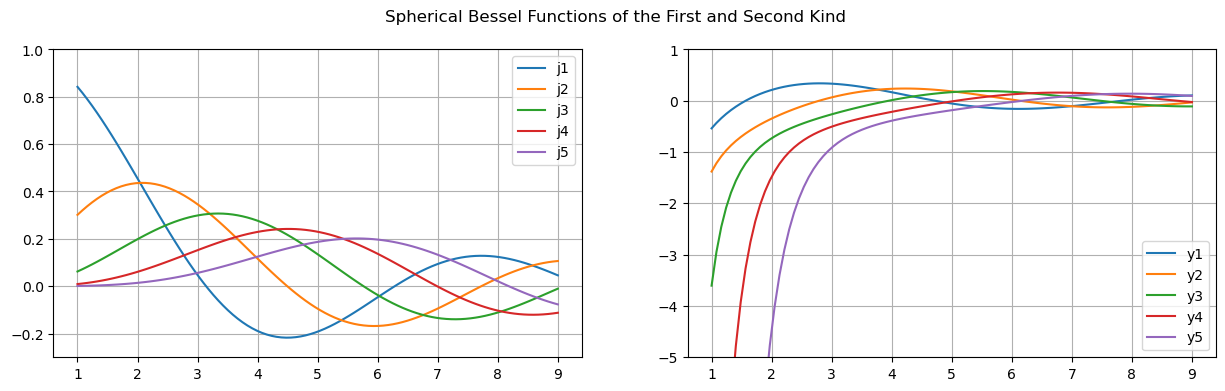

In [2]:
xvals = np.linspace(1.0, 9.0, 100)

j_1 = sp.spherical_jn(n = 0, z = xvals, derivative = False)
j_2 = sp.spherical_jn(n = 1, z = xvals, derivative = False)
j_3 = sp.spherical_jn(n = 2, z = xvals, derivative = False)
j_4 = sp.spherical_jn(n = 3, z = xvals, derivative = False)
j_5 = sp.spherical_jn(n = 4, z = xvals, derivative = False)

y_1 = sp.spherical_yn(n = 0, z = xvals, derivative = False)
y_2 = sp.spherical_yn(n = 1, z = xvals, derivative = False)
y_3 = sp.spherical_yn(n = 2, z = xvals, derivative = False)
y_4 = sp.spherical_yn(n = 3, z = xvals, derivative = False)
y_5 = sp.spherical_yn(n = 4, z = xvals, derivative = False)

fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(xvals, j_1, label = 'j1')
ax[0].plot(xvals, j_2, label = 'j2')
ax[0].plot(xvals, j_3, label = 'j3')
ax[0].plot(xvals, j_4, label = 'j4')
ax[0].plot(xvals, j_5, label = 'j5')
ax[0].set_ylim(-0.3,1)
ax[0].grid()
ax[0].legend()

ax[1].plot(xvals, y_1, label = 'y1')
ax[1].plot(xvals, y_2, label = 'y2')
ax[1].plot(xvals, y_3, label = 'y3')
ax[1].plot(xvals, y_4, label = 'y4')
ax[1].plot(xvals, y_5, label = 'y5')
ax[1].set_ylim(-5,1)
ax[1].grid()
ax[1].legend()

fig.suptitle('Spherical Bessel Functions of the First and Second Kind')
plt.show()

### $\textit{Importing data}$

In [3]:
def import_data(filename): # filename with quotations
    '''
    Imports wavelength and index of refraction data from a csv file
    '''
    df = pd.read_csv(filename, sep = ',')

    # Read values of wavelength and index of refraction

    ref_lam = df.iloc[0:,0]
    ref_n = df.iloc[0:,1]   # real part of index of refraction
    ref_k = df.iloc[0:,2]   # complex part of index of refraction

    # Convert data into arrays

    ref_lam = ref_lam.to_numpy()
    ref_n = ref_n.to_numpy()
    ref_k = ref_k.to_numpy()
    return ref_lam, ref_n, ref_k

In [4]:
ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
m_silver = ref_n_silver + 1j * ref_k_silver # SIGN!!!!!!!!
ref_lam_gold, ref_n_gold, ref_k_gold = import_data("McPeak_gold.csv")
m_gold = ref_n_gold + 1j * ref_k_gold # SIGN!!!!!!!!

### $\textit{Calculating decay rates}$

In [11]:
def a_1_b_1_lists_TRIAL(d_points, ref_ind, lam_val, r, n = 1, order = 1, plot = False):   
    
    '''
    Outputs lists of a_1 and b_1 Mie scattering coefficients and corresponding gamma factors (total and radiative for both vertical
    and horizontal orientations) as defined in YSK paper for an input list of wavelengths and corresponding
    refractive indices.
    
    ref_ind - list of refractive indices [dimensionless]
    lam_list - list of wavelengths corresponding to refr_ind [μm]
    r - radius of particle [μm]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''

    eps1 = 1.0
    eps2 = ref_ind**2
    k1 = 2 * np.sqrt(eps1) * np.pi / lam_val # surrounding medium (vacuum)
    k2 = 2 * ref_ind * np.pi / lam_val# nanoparticle
    rho1 = k1*r
    rho2 = k2*r

    gamma_norm_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_vals = np.zeros_like(d_points, dtype = float)
    gamma_norm_rad_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_rad_vals = np.zeros_like(d_points, dtype = float)
    
    A_list = np.zeros((order,len(d_points)), dtype = complex)
    B_list = np.zeros((order,len(d_points)), dtype = complex)

    j = 0
    for d in d_points:
        #dis = r + d
        y1 = k1*d 

        gamma_norm_sum = 0.0
        gamma_tang_sum = 0.0
        gamma_norm_rad_sum = 0.0
        gamma_tang_rad_sum = 0.0
        for i in range(1,order+1):
            j_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = False)
            j_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = False)
            y_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = False)
            y_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = False)
            h1_rho1 = j_rho1 + 1j*y_rho1
            h1_rho2 = j_rho2 + 1j*y_rho2
            
            j_prime_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = True)
            j_prime_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = True)
            y_prime_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = True)
            y_prime_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = True)
            h1_prime_rho1 = j_prime_rho1 + 1j*y_prime_rho1
            h1_prime_rho2 = j_prime_rho2 + 1j*y_prime_rho2
    
            psi_rho1 = rho1*j_rho1
            psi_rho2 = rho2*j_rho2
            psi_prime_rho1 = rho1*j_prime_rho1 + j_rho1
            psi_prime_rho2 = rho2*j_prime_rho2 + j_rho2
            
            xi_rho1 = rho1*h1_rho1
            xi_rho2 = rho2*h1_rho2
            xi_prime_rho1 = rho1*h1_prime_rho1 + h1_rho1
            xi_prime_rho2 = rho2*h1_prime_rho2 + h1_rho2

            j1_y1 = sp.spherical_jn(n = i, z = y1, derivative = False)
            y1_y1 = sp.spherical_yn(n = i, z = y1, derivative = False)
            h1_y1 = j1_y1 + 1j*y1_y1
            j_prime_y1 = sp.spherical_jn(n = i, z = y1, derivative = True)
            y_prime_y1 = sp.spherical_yn(n = i, z = y1, derivative = True)
            h1_prime_y1 = j_prime_y1 + 1j*y_prime_y1
        
            psi_y1 = y1*j1_y1
            psi_prime_y1 = y1*j_prime_y1 + j1_y1
            xi_y1 = y1*h1_y1
            xi_prime_y1 = y1*h1_prime_y1 + h1_y1

            numerator_A = j_rho1*psi_prime_rho2 - j_rho2*psi_prime_rho1
            denominator_A = j_rho2*xi_prime_rho1 - h1_rho1*psi_prime_rho2

            numerator_B = eps1*j_rho1*psi_prime_rho2 - eps2*j_rho2*psi_prime_rho1
            denominator_B = eps2*j_rho2*xi_prime_rho1 - eps1*h1_rho1*psi_prime_rho2
    
            A_i = numerator_A / denominator_A
            B_i = numerator_B / denominator_B

            A_list[i-1,j] = A_i
            B_list[i-1,j] = B_i

            g_norm_i = (2*i+1)*i*(i+1)*B_i*((h1_y1/y1)**2)
            gamma_norm_sum = gamma_norm_sum + g_norm_i
            g_norm_rad_i = i*(i+1)*(2*i+1)*((abs((j1_y1 + B_i*h1_y1)/y1))**2)
            gamma_norm_rad_sum = gamma_norm_rad_sum + g_norm_rad_i
    
            g_tang_i = (i+0.5)*(B_i*((xi_prime_y1/y1)**2) + A_i*((h1_y1)**2))
            gamma_tang_sum = gamma_tang_sum + g_tang_i
    
            g_tang_rad_i = (2*i+1)*((abs(j1_y1 + A_i*h1_y1))**2 + (abs((psi_prime_y1 + B_i*xi_prime_y1)/y1))**2)
            gamma_tang_rad_sum = gamma_tang_rad_sum + g_tang_rad_i

        gamma_norm = 1 + 1.5*gamma_norm_sum.real
        gamma_tang = 1 + 1.5*gamma_tang_sum.real
        gamma_norm_rad = 1.5*gamma_norm_rad_sum
        gamm_tang_rad = 0.75*gamma_tang_rad_sum
        
        gamma_norm_vals[j] = gamma_norm
        gamma_tang_vals[j] = gamma_tang
        gamma_norm_rad_vals[j] = gamma_norm_rad
        gamma_tang_rad_vals[j] = gamm_tang_rad
        j += 1 

    if plot:
        fig, ax = plt.subplots(1,1, figsize = (9, 9))
        ax.plot(d_points/a, gamma_norm_vals, label = '$\gamma_{\perp}$')
        ax.plot(d_points/a, gamma_tang_vals, label = '$\gamma_{\, \|}$')
        ax.plot(d_points/a, gamma_norm_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\perp}$')  
        ax.plot(d_points/a, gamma_tang_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\, \|}$')
        ax.set_xlabel('d/a', fontsize=14)
        ax.set_ylabel('$\gamma / \gamma_0$', fontsize=14)
        ax.set_ylim(0,2)
        ax.minorticks_on()
        ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.3)
        ax.grid(alpha = 0.2)
        ax.legend(fontsize=13)
        ax.set_title(f'Decay rates near spherical nanoparticle of radius a = {a*10**9} nm', fontsize=15, loc = 'center', wrap = True, pad=30)
        plt.show()
    return A_list, B_list, gamma_norm_vals, gamma_tang_vals, gamma_norm_rad_vals, gamma_tang_rad_vals

### $\textit{Comparison with Kim et al paper}$

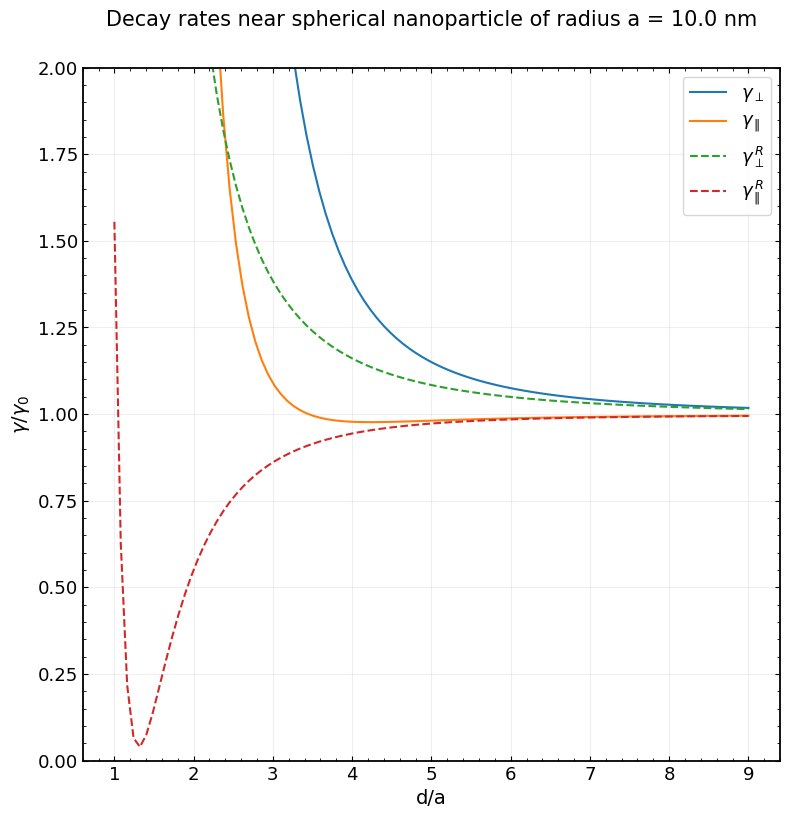

In [12]:
a = 100e-10  # radius of the sphere in meters (100 Ångström)
lam = 4133e-10  # emission wavelength in meters (4133 Ångström)
mval = np.sqrt(-4.42 + 0.73j)  # complex dielectric constant of the sphere
dpoints = np.linspace(1.0, 9.0, 100) * a
A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = \
a_1_b_1_lists_TRIAL(dpoints, mval, lam, a, n = 1, order = 5, plot = True) 

### $\textit{Silver - wavelength of highest field intensity}$

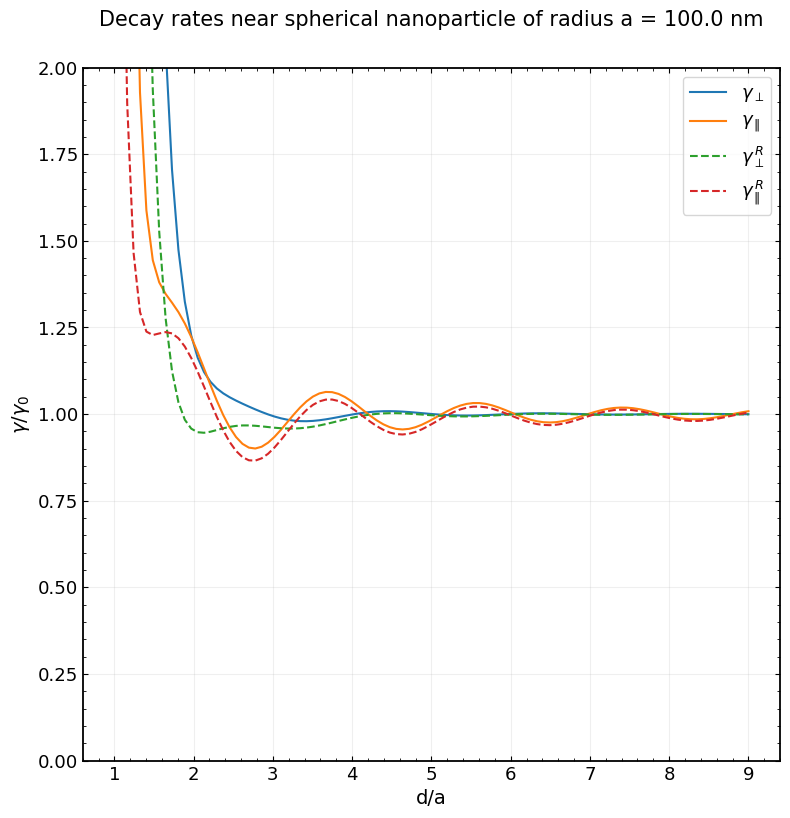

In [13]:
a = 100e-9  # radius of the sphere in meters (10 nm)
lam = 0.36  # emission wavelength in meters (360 nm)
index = np.where(ref_lam_silver == lam)
mval = m_silver[index][0]
dpoints = np.linspace(1.0, 9.0, 100) * a
A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = \
a_1_b_1_lists_TRIAL(dpoints, mval, lam*1e-6, a, n = 1, order = 25, plot = True) 

### $\textit{Gold}$

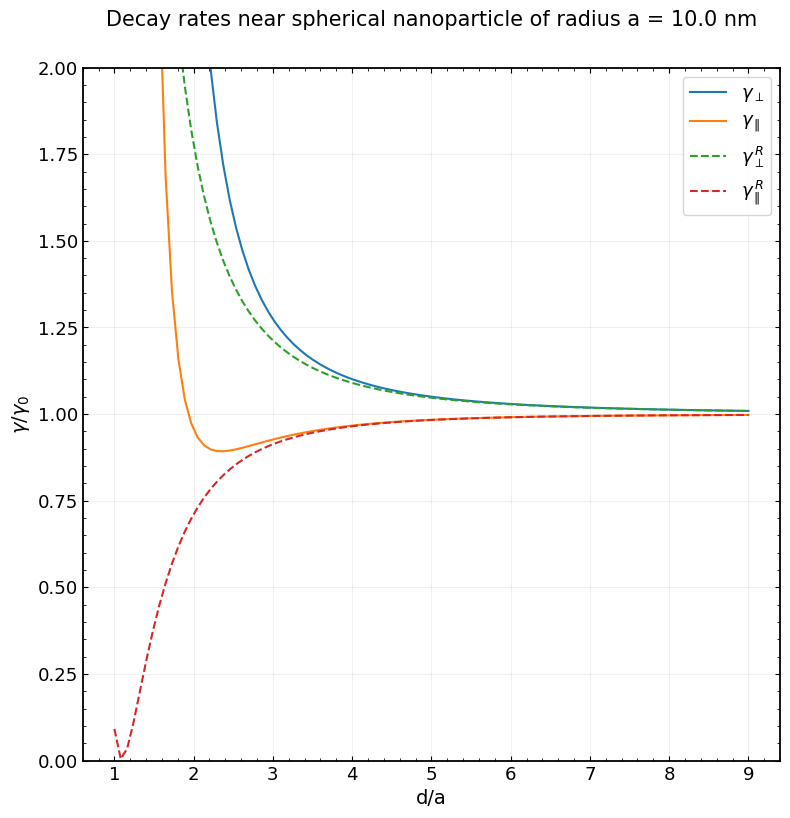

In [14]:
a = 10e-9  # radius of the sphere in meters (10 nm)
lam = 0.54  # emission wavelength in meters (360 nm)
index = np.where(ref_lam_gold == lam)
mval = m_silver[index][0]
dpoints = np.linspace(1.0, 9.0, 100) * a
A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = \
a_1_b_1_lists_TRIAL(dpoints, mval, lam*1e-6, a, n = 1, order = 5, plot = True) 